<a href="https://colab.research.google.com/github/dav1dbai/CAIS_FER/blob/main/CAISMiniProj_FER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

100%|██████████| 60.3M/60.3M [00:03<00:00, 17.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/msambare/fer2013/versions/1


In [2]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.io import read_image
from torchvision.transforms import ToTensor
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import f1_score, classification_report

In [7]:
class ImageDataset(Dataset):
    classes = {
        'angry': 0,
        'disgust': 1,
        'fear': 2,
        'happy': 3,
        'sad': 4,
        'surprise': 5,
        'neutral': 6
    }

    def __init__(self, path, is_train=True):
        self.labels = []
        self.images = []

        for filename in os.listdir(path):
            if filename in self.classes:
                self.label = self.classes[filename]
                for filename_ in os.listdir(path + filename):
                    self.labels.append(self.label)
                    self.images.append(path + filename + '/' + filename_)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        image_path = self.images[idx]

        try:
            image = read_image(image_path)

            image = image.float()
            image = image / 255.0

            return label, image

        except Exception as e:
            print(f"Error reading image {image_path}: {str(e)}")
            return torch.zeros((1, 48, 48)), label

7178
(5, tensor([[[0.0627, 0.1255, 0.1922,  ..., 0.9020, 0.9020, 0.9020],
         [0.0824, 0.1255, 0.2314,  ..., 0.9059, 0.9059, 0.9059],
         [0.0941, 0.1686, 0.2706,  ..., 0.9059, 0.9059, 0.9059],
         ...,
         [0.1647, 0.1569, 0.1882,  ..., 0.9098, 0.9098, 0.9098],
         [0.1804, 0.1725, 0.1765,  ..., 0.9098, 0.9098, 0.9098],
         [0.1490, 0.2039, 0.1569,  ..., 0.9098, 0.9098, 0.9098]]]))


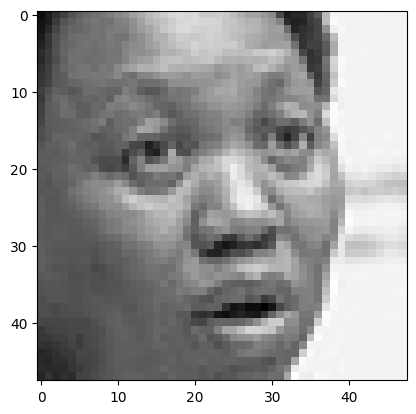

In [8]:
test_dataset = ImageDataset(path+'/test/')
print(len(test_dataset))
print(test_dataset[0])
plt.imshow(test_dataset[0][1].permute(1,2,0), cmap='gray')

In [17]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()

        self.skip = nn.Sequential()
        if in_channels != out_channels:
            self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        residual = self.skip(x)
        out = self.relu1(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = self.relu2(out)
        return out

class model(nn.Module):
    def __init__(self):
        super().__init__()

        self.initial = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.layer1 = ResBlock(32, 32)
        self.layer2 = ResBlock(32, 64)
        self.layer3 = ResBlock(64, 128)

        self.pool = nn.AdaptiveAvgPool2d((6, 6))

        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 6 * 6, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 7)
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [10]:
def prepare_dataloaders(path, batch_size=8):

    train_dataset = ImageDataset(path + '/train/')
    test_dataset = ImageDataset(path + '/test/', is_train=False)


    train_labels = [label for label, _ in train_dataset]


    train_indices, val_indices = train_test_split(
        range(len(train_dataset)),
        train_size=0.7,
        stratify=train_labels,
        random_state=42
    )


    train_subset = torch.utils.data.Subset(train_dataset, train_indices)
    val_subset = torch.utils.data.Subset(train_dataset, val_indices)


    train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print("Dataset splits (Train/Val/Test):",
          len(train_subset), len(val_subset), len(test_dataset))

    return train_dataloader, val_dataloader, test_dataloader

In [11]:
def train_model(train_dataloader, val_dataloader, model):
    optimizer = torch.optim.AdamW(params=model.parameters(), lr=0.0001)
    loss_fn = nn.CrossEntropyLoss()
    epochs = 20
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)


    best_val_acc = 0

    for epoch in range(epochs):
        model.train()
        train_loss, train_acc = 0, 0
        num_train_samples = 0

        train_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1} Training",
                        leave=False)

        for batch, (label,img) in enumerate(train_bar):
            label, img = label.to(device), img.to(device)
            batch_size = img.size(0)

            optimizer.zero_grad()
            logits = model(img)
            loss = loss_fn(logits, label)

            loss.backward()
            optimizer.step()

            pred = logits.argmax(dim=1)
            batch_acc = (pred == label).sum().item()

            train_loss += loss.item() * batch_size
            train_acc += batch_acc
            num_train_samples += batch_size

            train_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{batch_acc/batch_size:.4f}'
            })

        train_loss = train_loss / num_train_samples
        train_acc = train_acc / num_train_samples

        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

        model.eval()
        val_loss, val_acc = 0, 0
        num_val_samples = 0

        with torch.no_grad():
            val_bar = tqdm(val_dataloader, desc=f"Epoch {epoch+1} Validation",
                          leave=False)

            for batch, (label, img) in enumerate(val_bar):
                img, label = img.to(device), label.to(device)
                batch_size = img.size(0)

                logits = model(img)
                loss = loss_fn(logits, label)

                pred = logits.argmax(dim=1)
                batch_acc = (pred == label).sum().item()

                val_loss += loss.item() * batch_size
                val_acc += batch_acc
                num_val_samples += batch_size

                val_bar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{batch_acc/batch_size:.4f}'
                })

        val_loss = val_loss / num_val_samples
        val_acc = val_acc / num_val_samples

        print(f"Epoch {epoch+1}: Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

    return model

In [12]:
def test_model(test_dataloader, model):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    loss_fn = nn.CrossEntropyLoss()
    model.to(device)
    model.eval()
    test_loss, test_acc = 0, 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch, (label, img) in enumerate(test_dataloader):
            img, label = img.to(device), label.to(device)
            logits = model(img)
            loss = loss_fn(logits, label)
            test_loss += loss.item()
            pred = logits.argmax(dim=1)
            test_acc += (pred == label).sum().item()/len(pred)

            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

        weighted_f1 = f1_score(all_labels, all_preds, average='weighted')

        class_names = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
        report = classification_report(all_labels, all_preds, target_names=class_names)

        print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Weighted F1: {weighted_f1:.4f}")
        print("\nDetailed Classification Report:")
        print(report)

    return test_loss, test_acc, weighted_f1, report

In [13]:
train_dataloader, val_dataloader, test_dataloader = prepare_dataloaders(path)

Dataset splits (Train/Val/Test): 20096 8613 7178


In [18]:
if __name__ == "__main__":
  model_instance = model()
  trained_model = train_model(train_dataloader, val_dataloader, model_instance)
  test_model(test_dataloader, trained_model)

Epoch 1: Train Loss: 1.6096, Train Acc: 0.3657


Epoch 1: Val Loss: 1.4279, Val Acc: 0.4463


Epoch 2: Train Loss: 1.3945, Train Acc: 0.4626


Epoch 2: Val Loss: 1.2980, Val Acc: 0.5020


Epoch 3: Train Loss: 1.3079, Train Acc: 0.5024


Epoch 3: Val Loss: 1.2574, Val Acc: 0.5142


Epoch 4: Train Loss: 1.2422, Train Acc: 0.5294


Epoch 4: Val Loss: 1.2147, Val Acc: 0.5388


Epoch 5: Train Loss: 1.1854, Train Acc: 0.5466


Epoch 5: Val Loss: 1.1584, Val Acc: 0.5567


Epoch 6: Train Loss: 1.1439, Train Acc: 0.5695


Epoch 6: Val Loss: 1.1500, Val Acc: 0.5607


Epoch 7: Train Loss: 1.1041, Train Acc: 0.5840


Epoch 7: Val Loss: 1.1099, Val Acc: 0.5776


Epoch 8: Train Loss: 1.0715, Train Acc: 0.5967


Epoch 8: Val Loss: 1.1016, Val Acc: 0.5848


Epoch 9: Train Loss: 1.0394, Train Acc: 0.6091


Epoch 9: Val Loss: 1.0928, Val Acc: 0.5881


Epoch 10: Train Loss: 1.0087, Train Acc: 0.6213


Epoch 10: Val Loss: 1.0975, Val Acc: 0.5902


Epoch 11: Train Loss: 0.9781, Train Acc: 0.6306


Epoch 11: Val Loss: 1.0836, Val Acc: 0.5934


Epoch 12: Train Loss: 0.9529, Train Acc: 0.6411


Epoch 12: Val Loss: 1.0666, Val Acc: 0.5987


Epoch 13: Train Loss: 0.9255, Train Acc: 0.6512


Epoch 13: Val Loss: 1.0547, Val Acc: 0.6058


Epoch 14: Train Loss: 0.9018, Train Acc: 0.6607


Epoch 14: Val Loss: 1.0530, Val Acc: 0.6084


Epoch 15: Train Loss: 0.8746, Train Acc: 0.6714


Epoch 15: Val Loss: 1.0639, Val Acc: 0.6042


Epoch 16: Train Loss: 0.8469, Train Acc: 0.6812


Epoch 16: Val Loss: 1.0505, Val Acc: 0.6112


Epoch 17: Train Loss: 0.8267, Train Acc: 0.6915


Epoch 17: Val Loss: 1.0454, Val Acc: 0.6170


Epoch 18: Train Loss: 0.7977, Train Acc: 0.7024


Epoch 18: Val Loss: 1.0709, Val Acc: 0.6098


Epoch 19: Train Loss: 0.7749, Train Acc: 0.7137


Epoch 19: Val Loss: 1.0798, Val Acc: 0.6196


Epoch 20: Train Loss: 0.7611, Train Acc: 0.7178


Epoch 20: Val Loss: 1.0497, Val Acc: 0.6166
Test Loss: 1.0681, Test Acc: 0.6116, Weighted F1: 0.6104

Detailed Classification Report:
              precision    recall  f1-score   support

       angry       0.51      0.53      0.52       958
     disgust       0.68      0.49      0.57       111
        fear       0.46      0.36      0.40      1024
       happy       0.84      0.82      0.83      1774
         sad       0.45      0.50      0.47      1247
    surprise       0.75      0.75      0.75       831
     neutral       0.56      0.62      0.59      1233

    accuracy                           0.61      7178
   macro avg       0.61      0.58      0.59      7178
weighted avg       0.61      0.61      0.61      7178

